## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'batch0approx1e5-agriVision-fourier-green' # size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = False
CWD

'/Users/hannahchung/hierarchical-bayesian-model-validation/results/case-studies/agriVision/fourier/batch0approx1e5/green'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
else:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # For quick testing purposes
group_total_samples

{np.int32(2): 45000,
 np.int32(3): 72000,
 np.int32(4): 63000,
 np.int32(5): 117000,
 np.int32(6): 126000,
 np.int32(7): 171000,
 np.int32(8): 189000,
 np.int32(9): 297000,
 np.int32(10): 396000,
 np.int32(11): 495000,
 np.int32(12): 648000,
 np.int32(13): 882000,
 np.int32(14): 1134000,
 np.int32(15): 1539000,
 np.int32(16): 1953000,
 np.int32(17): 2574000,
 np.int32(18): 3456000,
 np.int32(19): 4563000,
 np.int32(20): 5967000,
 np.int32(21): 8010000,
 np.int32(22): 10395000,
 np.int32(23): 13887000,
 np.int32(24): 18297000,
 np.int32(25): 24057000,
 np.int32(26): 31968000,
 np.int32(27): 42183000,
 np.int32(28): 55764000,
 np.int32(29): 73701000,
 np.int32(30): 97326000}

In [5]:
''' Only need to run commented code once'''
all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
all_cdfs_df.head()

/Users/hannahchung/hierarchical-bayesian-model-validation/utilities/testing.py:820: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/hannahchung/hierarchical-bayesian-model-validation/utilities/testing.py:825: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/hannahchung/hierarchical-bayesian-model-validation/utilities/testing.py:825: RuntimeWarning: overflow encountered in scalar power
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/hannahchung/hierarchical-bayesian-model-validation/utilities/testing.py:825: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2


,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16


## Bootstrapping the Variance and Kurtosis

In [6]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [7]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,299433540.0,1.759341e+08,509074180.0,473.18463,99.150400,1014.4304,45000.0
5,198747680.0,9.555501e+07,699319550.0,2945.43360,103.131584,5357.3315,117000.0
8,63282876.0,3.527536e+07,138901260.0,918.95044,92.981850,2773.2476,189000.0
11,36580880.0,1.483858e+07,157073860.0,6517.12160,79.522800,6402.9790,495000.0
14,11849475.0,6.219774e+06,33301018.0,1856.47970,73.469666,4078.7040,1134000.0
17,7712681.0,2.961589e+06,38807548.0,9698.96400,65.483850,7453.9814,2574000.0
20,4424362.0,1.715440e+06,23333856.0,8663.62000,69.634030,7121.5830,5967000.0
23,1867623.2,6.293671e+05,12235534.0,16824.38000,62.493916,8304.5210,13887000.0
26,1038924.0,1.669297e+05,9786948.0,32372.20000,72.067810,9321.7900,31968000.0


## Initial Grid Search and Hypothesis Test Plots

In [8]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True)
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = master_df.loc[group, 'obs_var'],
                            best_param = initial_param)
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

        # Optional: Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05
band,,,,,,,,,,,
2,299433540.0,1.759341e+08,509074180.0,473.18463,99.150400,1014.4304,45000.0,0.16,1.0,0.012473,0.006398
5,198747680.0,9.555501e+07,699319550.0,2945.43360,103.131584,5357.3315,117000.0,0.17,1.3,0.012226,0.003969
8,63282876.0,3.527536e+07,138901260.0,918.95044,92.981850,2773.2476,189000.0,0.17,1.0,0.011484,0.003123
11,36580880.0,1.483858e+07,157073860.0,6517.12160,79.522800,6402.9790,495000.0,0.18,1.2,0.005725,0.001930
14,11849475.0,6.219774e+06,33301018.0,1856.47970,73.469666,4078.7040,1134000.0,0.18,0.9,0.004487,0.001275
17,7712681.0,2.961589e+06,38807548.0,9698.96400,65.483850,7453.9814,2574000.0,0.19,1.0,0.008769,0.000846
20,4424362.0,1.715440e+06,23333856.0,8663.62000,69.634030,7121.5830,5967000.0,0.20,1.2,0.008976,0.000556
23,1867623.2,6.293671e+05,12235534.0,16824.38000,62.493916,8304.5210,13887000.0,0.20,0.7,0.011148,0.000364
26,1038924.0,1.669297e+05,9786948.0,32372.20000,72.067810,9321.7900,31968000.0,0.20,0.1,0.012022,0.000240


### Search over $\eta=0$

In [9]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True)
            best_params_eta0.append(best_param_eta0[0])
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            best_params_eta0.append(master_df.loc[group, 'initial_r'])
    master_df['best_r_eta0'] = best_params_eta0
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0
band,,,,,,,,,,,,,
2,299433540.0,1.759341e+08,509074180.0,473.18463,99.150400,1014.4304,45000.0,0.16,1.0,0.012473,0.006398,0.048610,0.14
5,198747680.0,9.555501e+07,699319550.0,2945.43360,103.131584,5357.3315,117000.0,0.17,1.3,0.012226,0.003969,0.041049,0.14
8,63282876.0,3.527536e+07,138901260.0,918.95044,92.981850,2773.2476,189000.0,0.17,1.0,0.011484,0.003123,0.049271,0.15
11,36580880.0,1.483858e+07,157073860.0,6517.12160,79.522800,6402.9790,495000.0,0.18,1.2,0.005725,0.001930,0.033104,0.15
14,11849475.0,6.219774e+06,33301018.0,1856.47970,73.469666,4078.7040,1134000.0,0.18,0.9,0.004487,0.001275,0.046532,0.16
17,7712681.0,2.961589e+06,38807548.0,9698.96400,65.483850,7453.9814,2574000.0,0.19,1.0,0.008769,0.000846,0.032204,0.16
20,4424362.0,1.715440e+06,23333856.0,8663.62000,69.634030,7121.5830,5967000.0,0.20,1.2,0.008976,0.000556,0.031302,0.17
23,1867623.2,6.293671e+05,12235534.0,16824.38000,62.493916,8304.5210,13887000.0,0.20,0.7,0.011148,0.000364,0.024806,0.18
26,1038924.0,1.669297e+05,9786948.0,32372.20000,72.067810,9321.7900,31968000.0,0.20,0.1,0.012022,0.000240,0.019911,0.20


## Optimization

In [10]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

In [11]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True)

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0,best_r,best_eta,kstest_stat_best,iter1_r,iter1_eta,kstest_stat_iter1,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,299433540.0,1.759341e+08,509074180.0,473.18463,99.150400,1014.4304,45000.0,0.16,1.0,0.012473,0.006398,0.048610,0.14,0.161,1.10,0.008362,0.161,1.10,0.008362,25312
5,198747680.0,9.555501e+07,699319550.0,2945.43360,103.131584,5357.3315,117000.0,0.17,1.3,0.012226,0.003969,0.041049,0.14,0.168,1.21,0.009434,0.168,1.21,0.009434,21937
8,63282876.0,3.527536e+07,138901260.0,918.95044,92.981850,2773.2476,189000.0,0.17,1.0,0.011484,0.003123,0.049271,0.15,0.170,0.97,0.005886,0.170,0.97,0.005886,53155
11,36580880.0,1.483858e+07,157073860.0,6517.12160,79.522800,6402.9790,495000.0,0.18,1.2,0.005725,0.001930,0.033104,0.15,0.178,1.12,0.004567,0.178,1.12,0.004567,92812
14,11849475.0,6.219774e+06,33301018.0,1856.47970,73.469666,4078.7040,1134000.0,0.18,0.9,0.004487,0.001275,0.046532,0.16,0.182,0.99,0.002741,0.182,0.99,0.002741,239202
17,7712681.0,2.961589e+06,38807548.0,9698.96400,65.483850,7453.9814,2574000.0,0.19,1.0,0.008769,0.000846,0.032204,0.16,0.187,0.92,0.002548,0.187,0.92,0.002548,271476
20,4424362.0,1.715440e+06,23333856.0,8663.62000,69.634030,7121.5830,5967000.0,0.20,1.2,0.008976,0.000556,0.031302,0.17,0.198,1.10,0.007788,0.198,1.10,0.007788,29497
23,1867623.2,6.293671e+05,12235534.0,16824.38000,62.493916,8304.5210,13887000.0,0.20,0.7,0.011148,0.000364,0.024806,0.18,0.198,0.61,0.007247,0.198,0.61,0.007247,34326
26,1038924.0,1.669297e+05,9786948.0,32372.20000,72.067810,9321.7900,31968000.0,0.20,0.1,0.012022,0.000240,0.019911,0.20,0.198,0.03,0.006817,0.198,0.03,0.006817,39508


## Comparing Empirical and Computed CDF/PDF

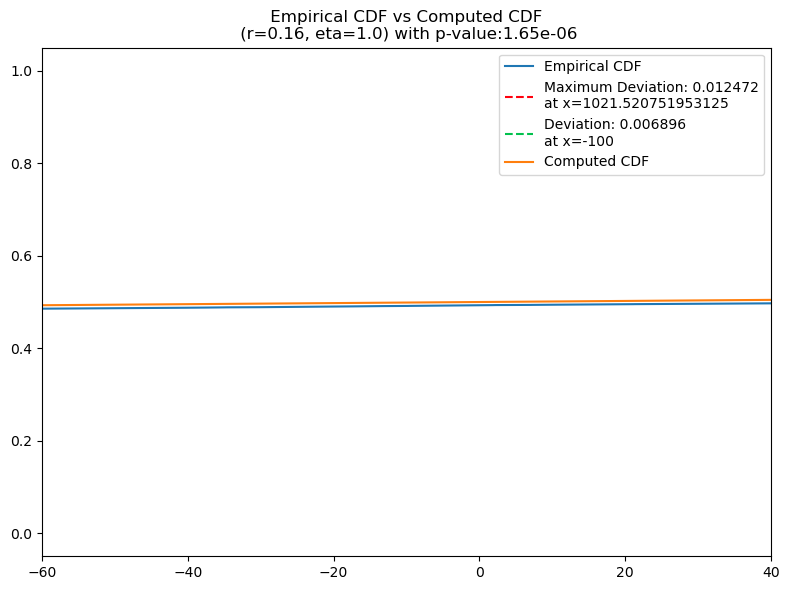

In [12]:
# Example Cell
group = 2
visualize_cdf(sample = group_data_map[group], 
              all_cdfs = None, 
              params = (float(master_df.loc[group, 'initial_r']), float(master_df.loc[group, 'initial_eta'])),
              distro = 'gengamma',
              n_samples=200, 
              interval = (-60, 40), 
              provided_loc = -100);

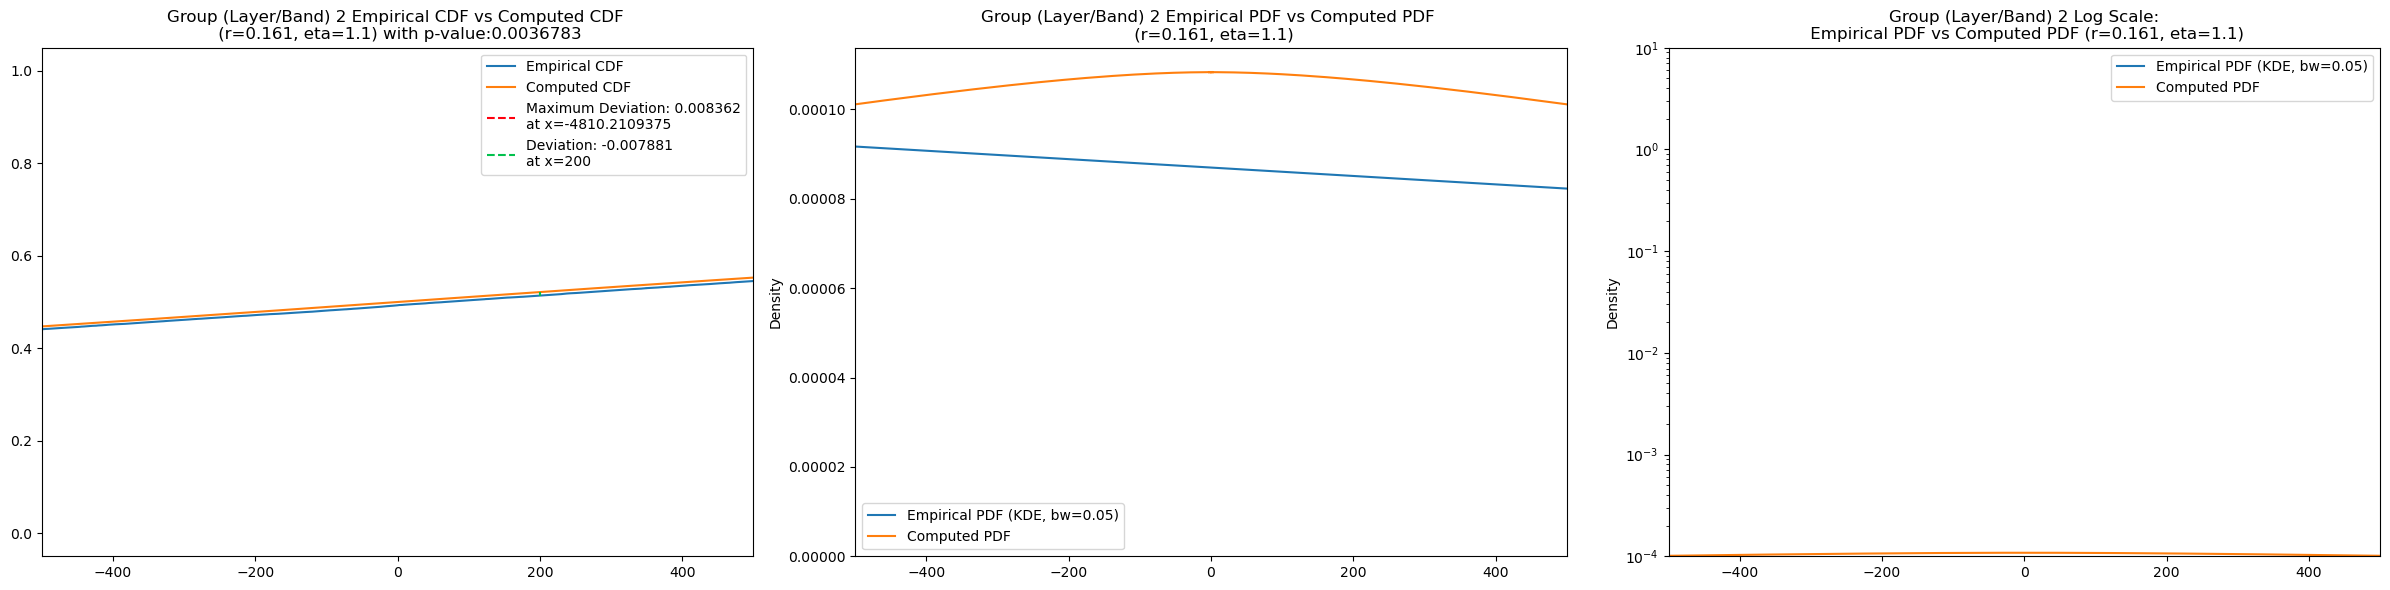

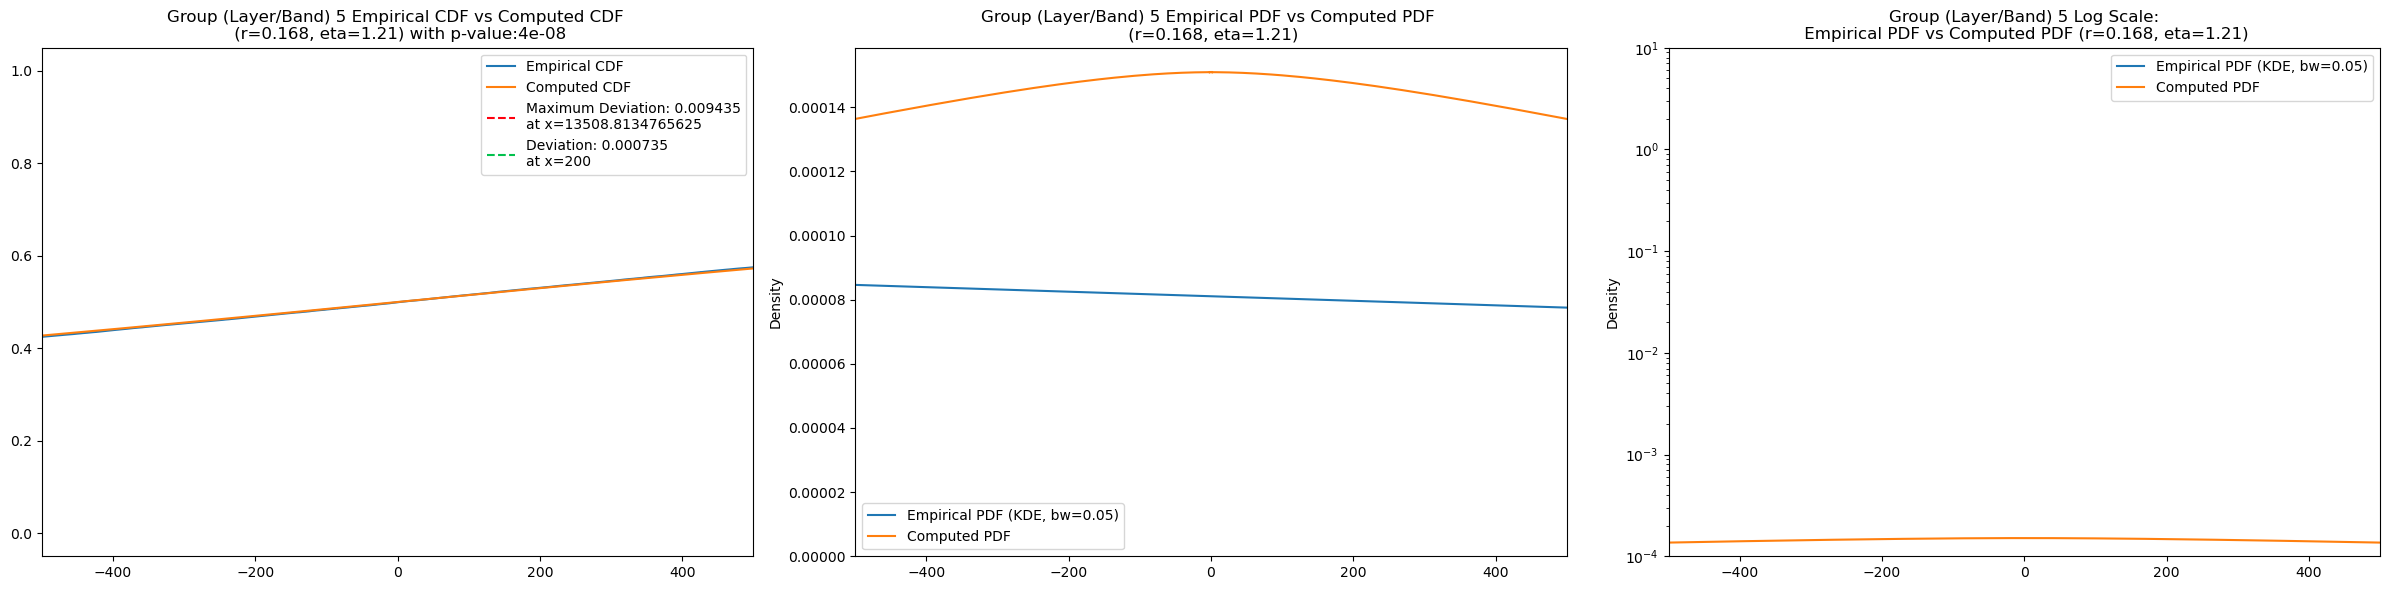

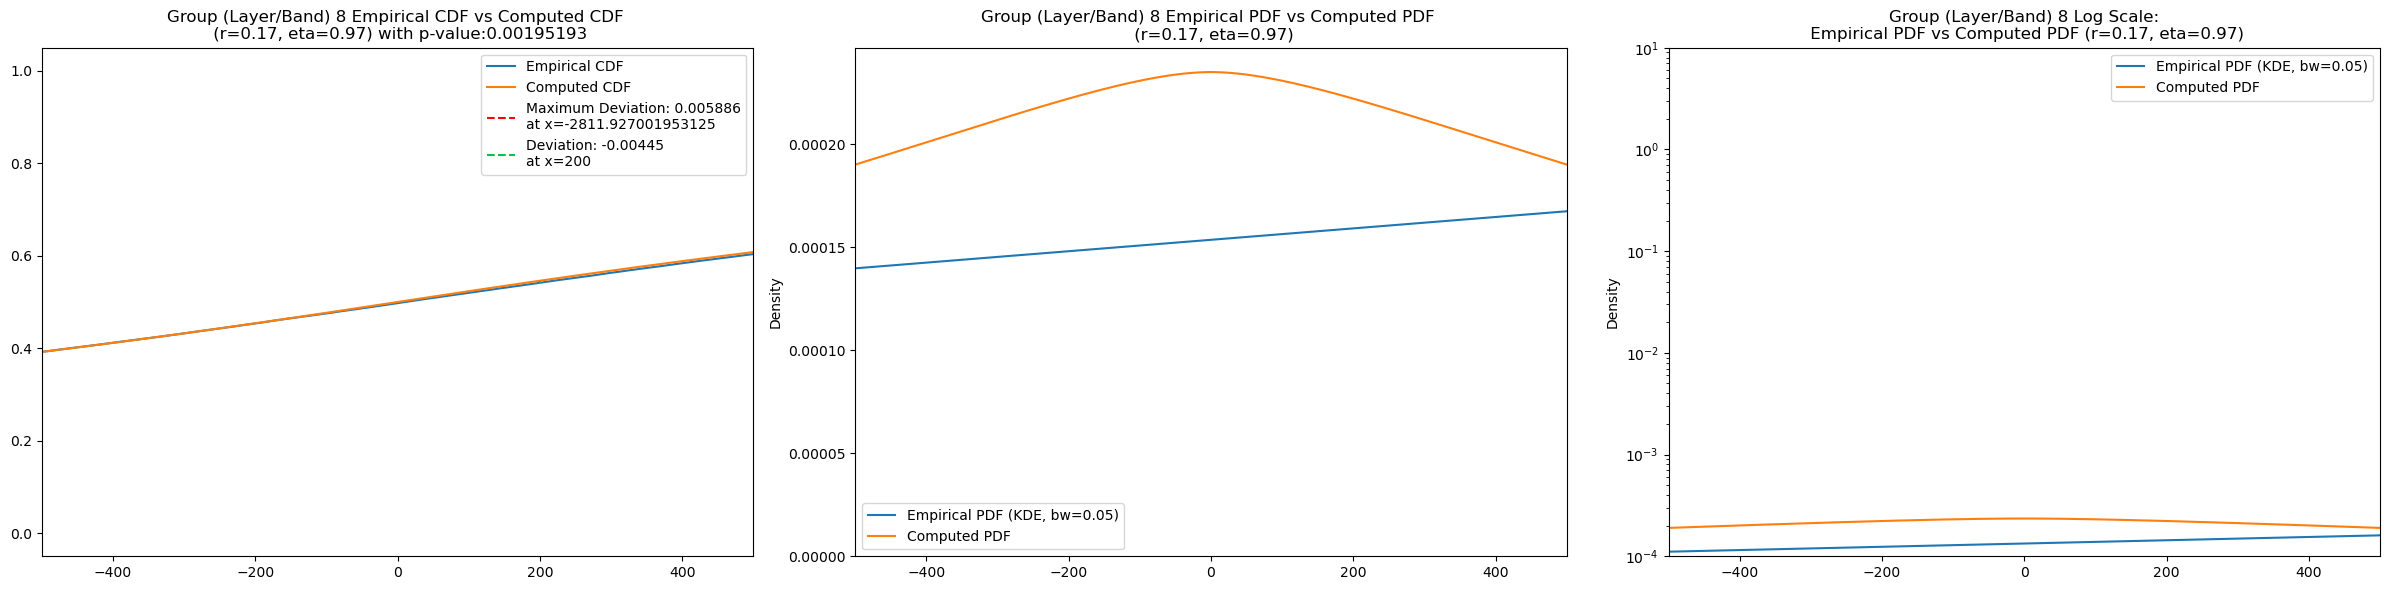

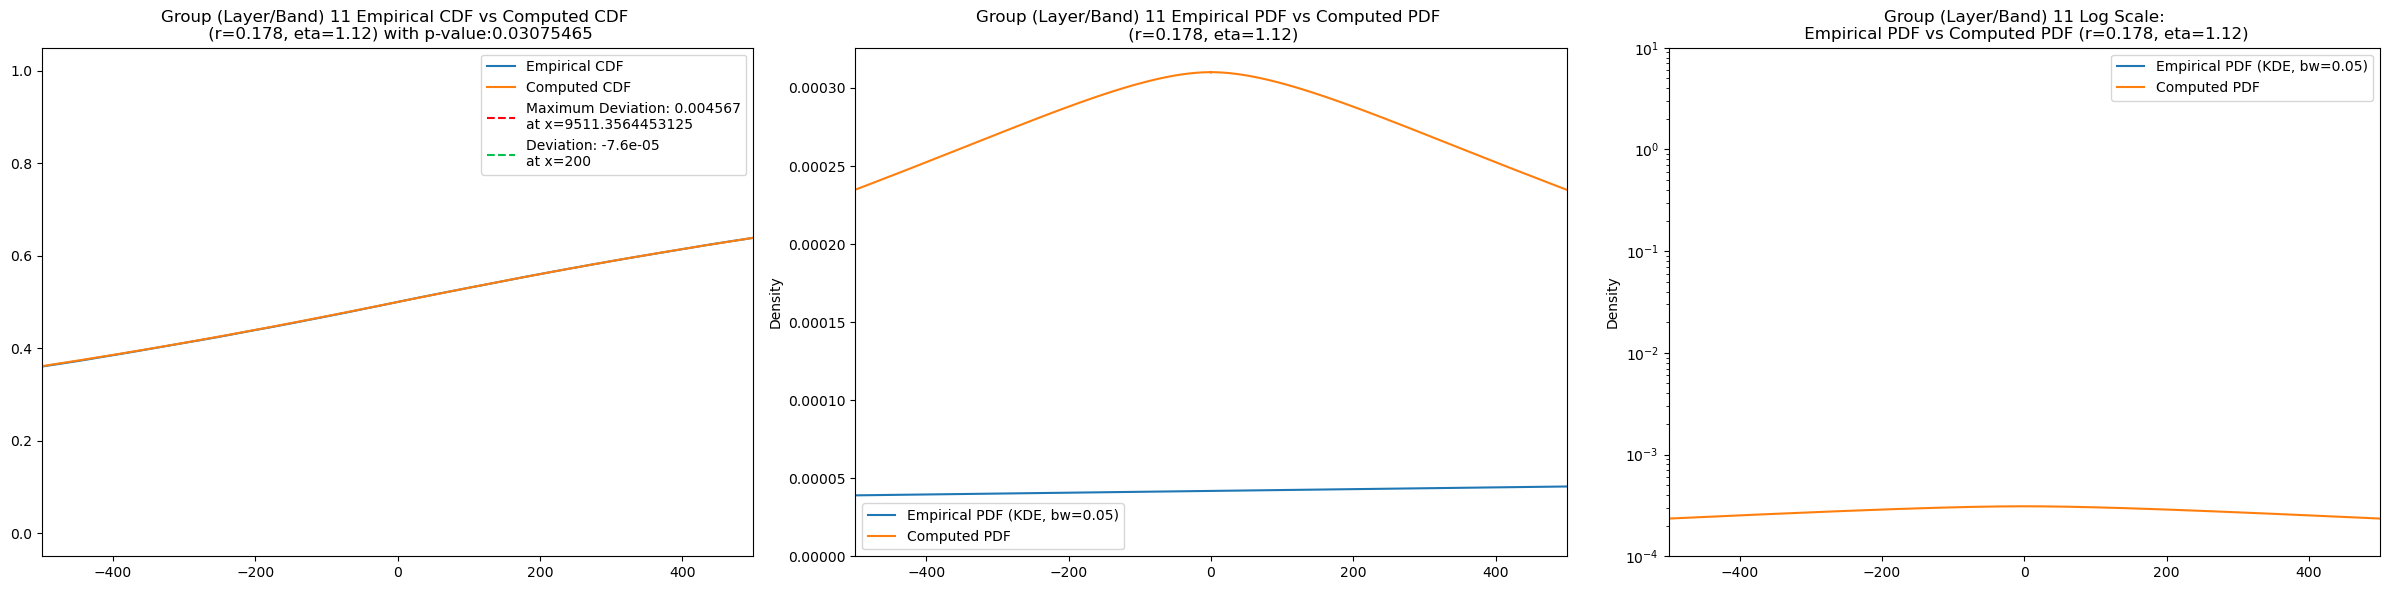

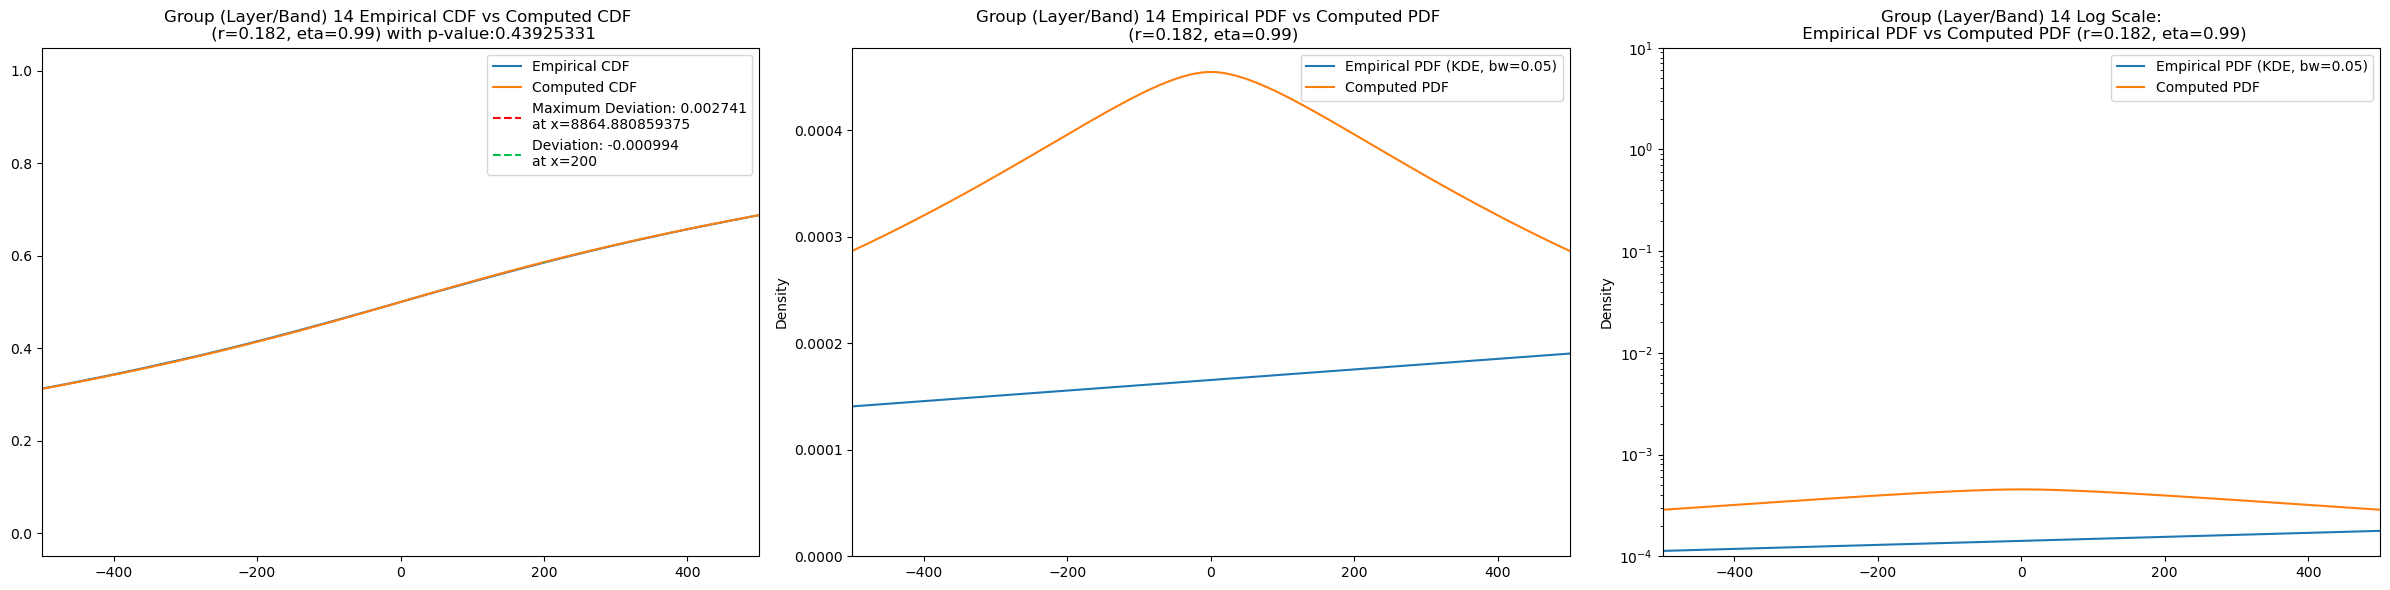

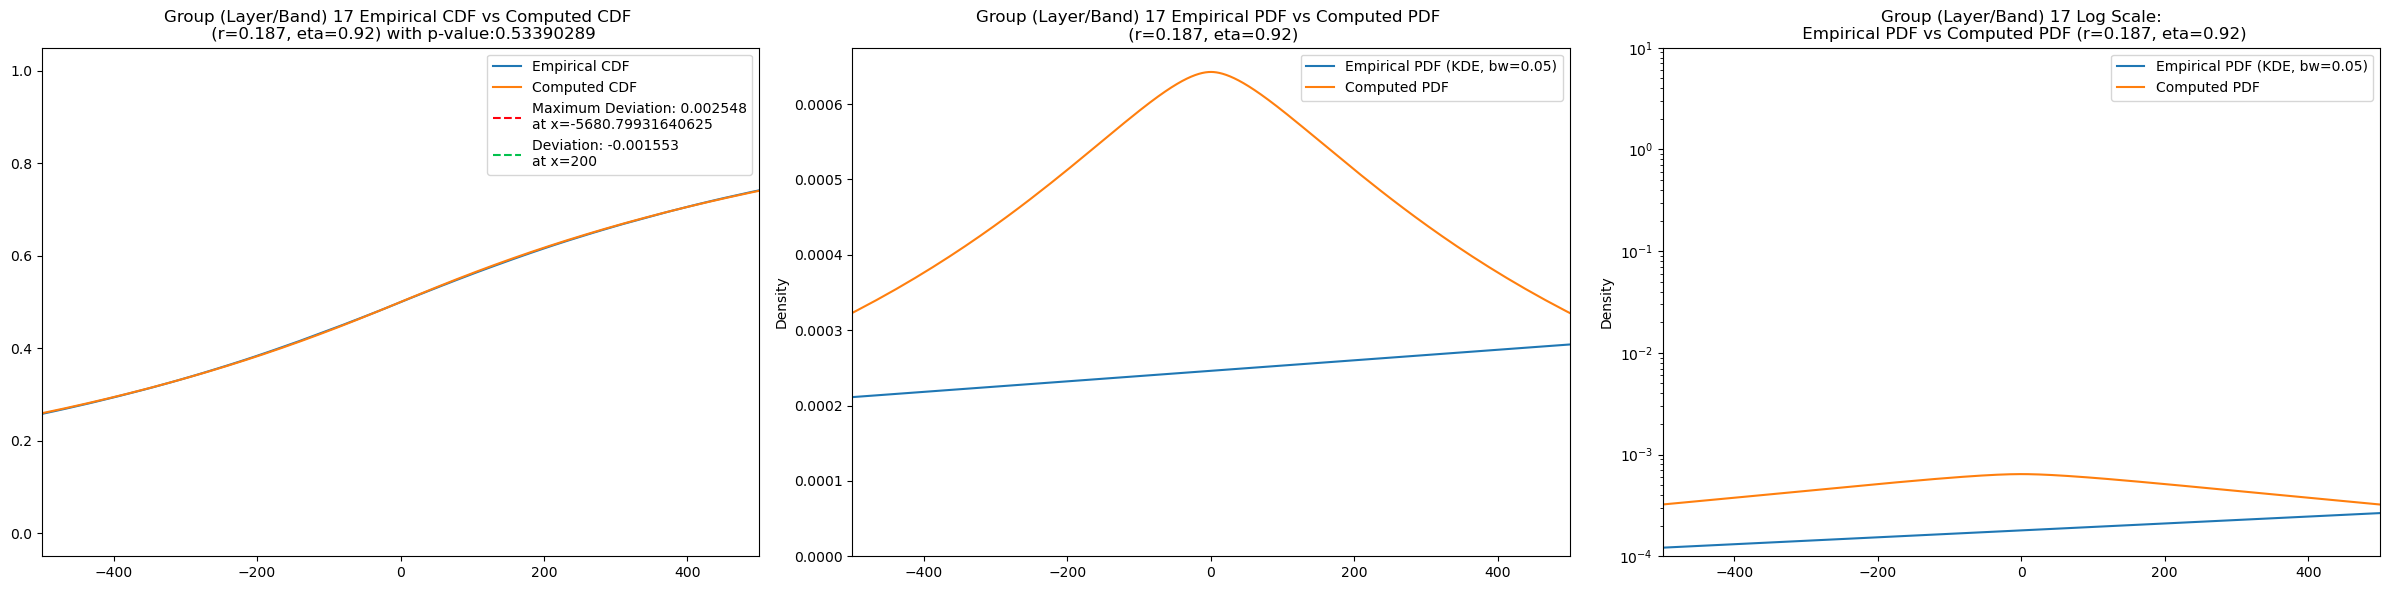

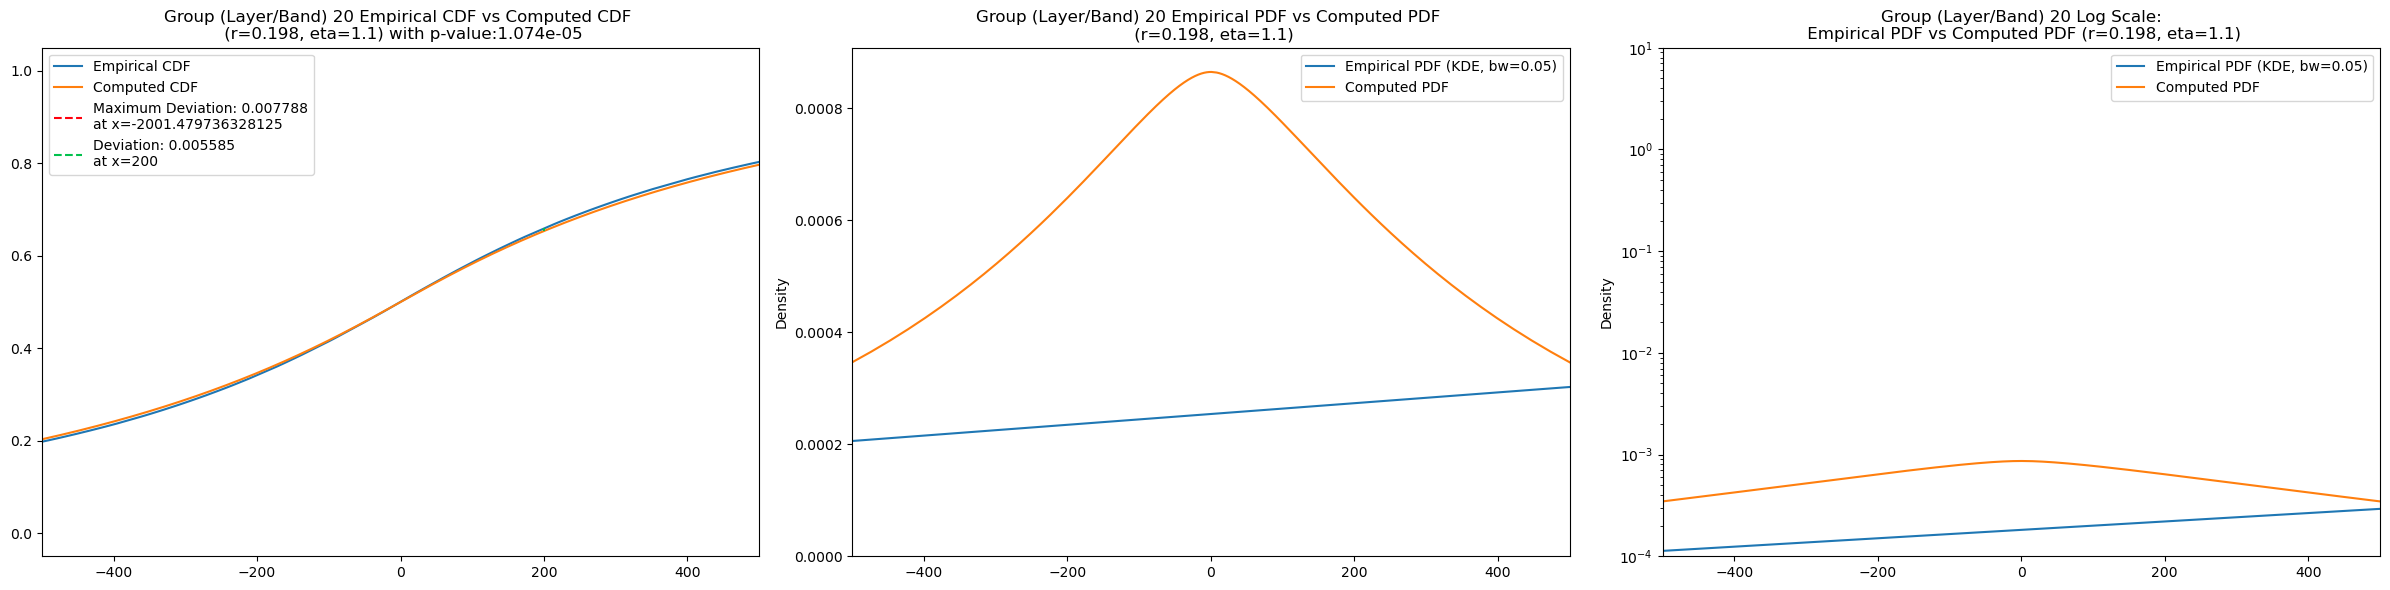

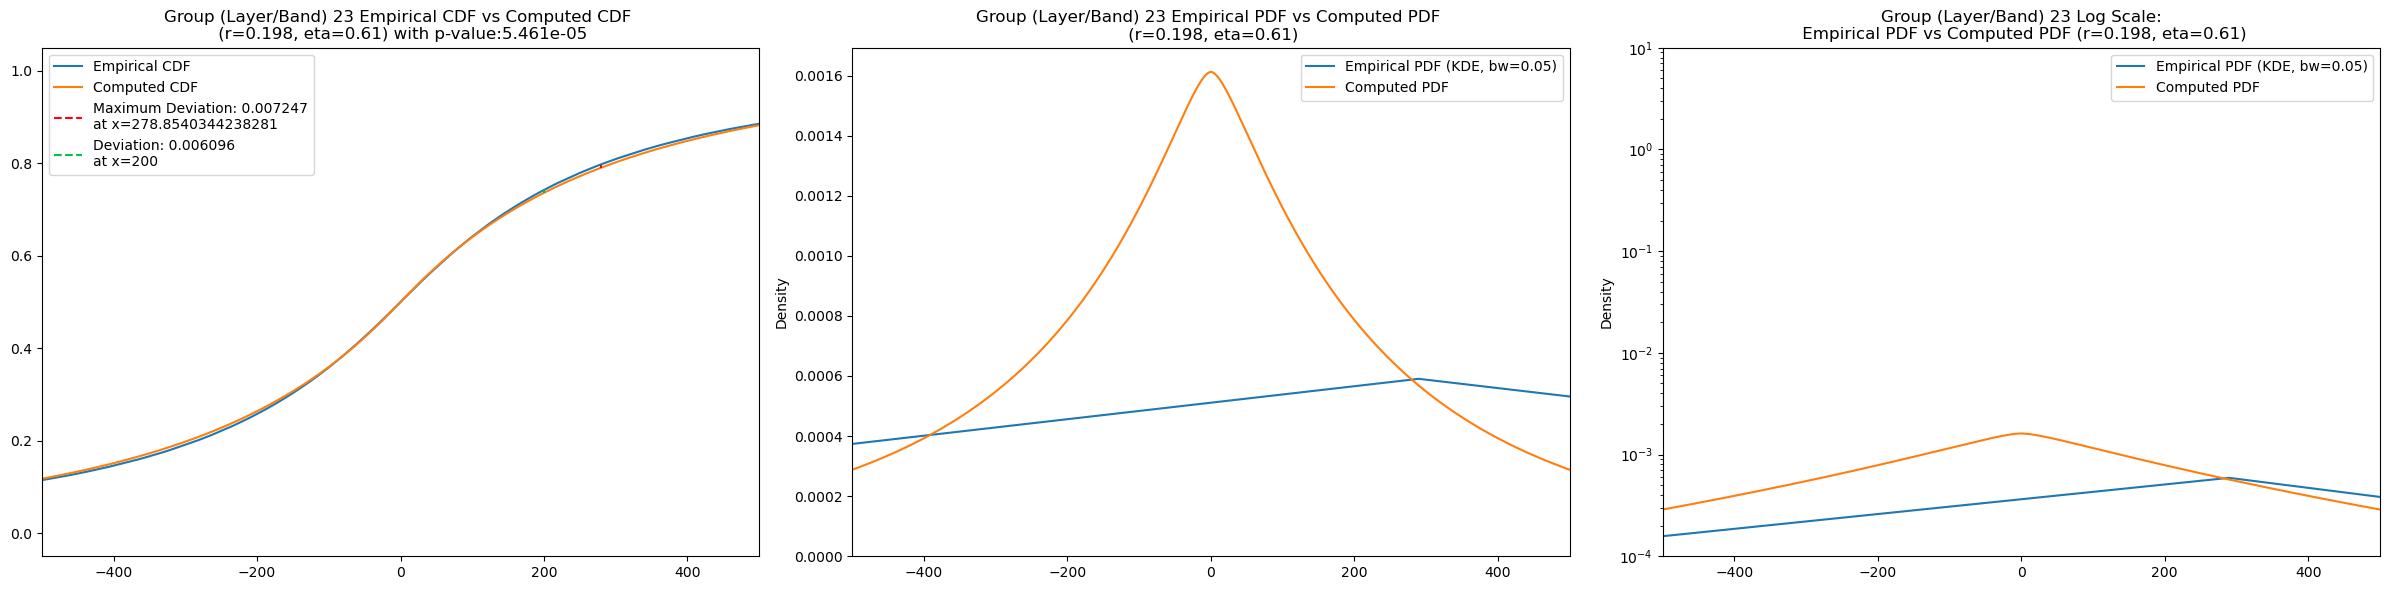

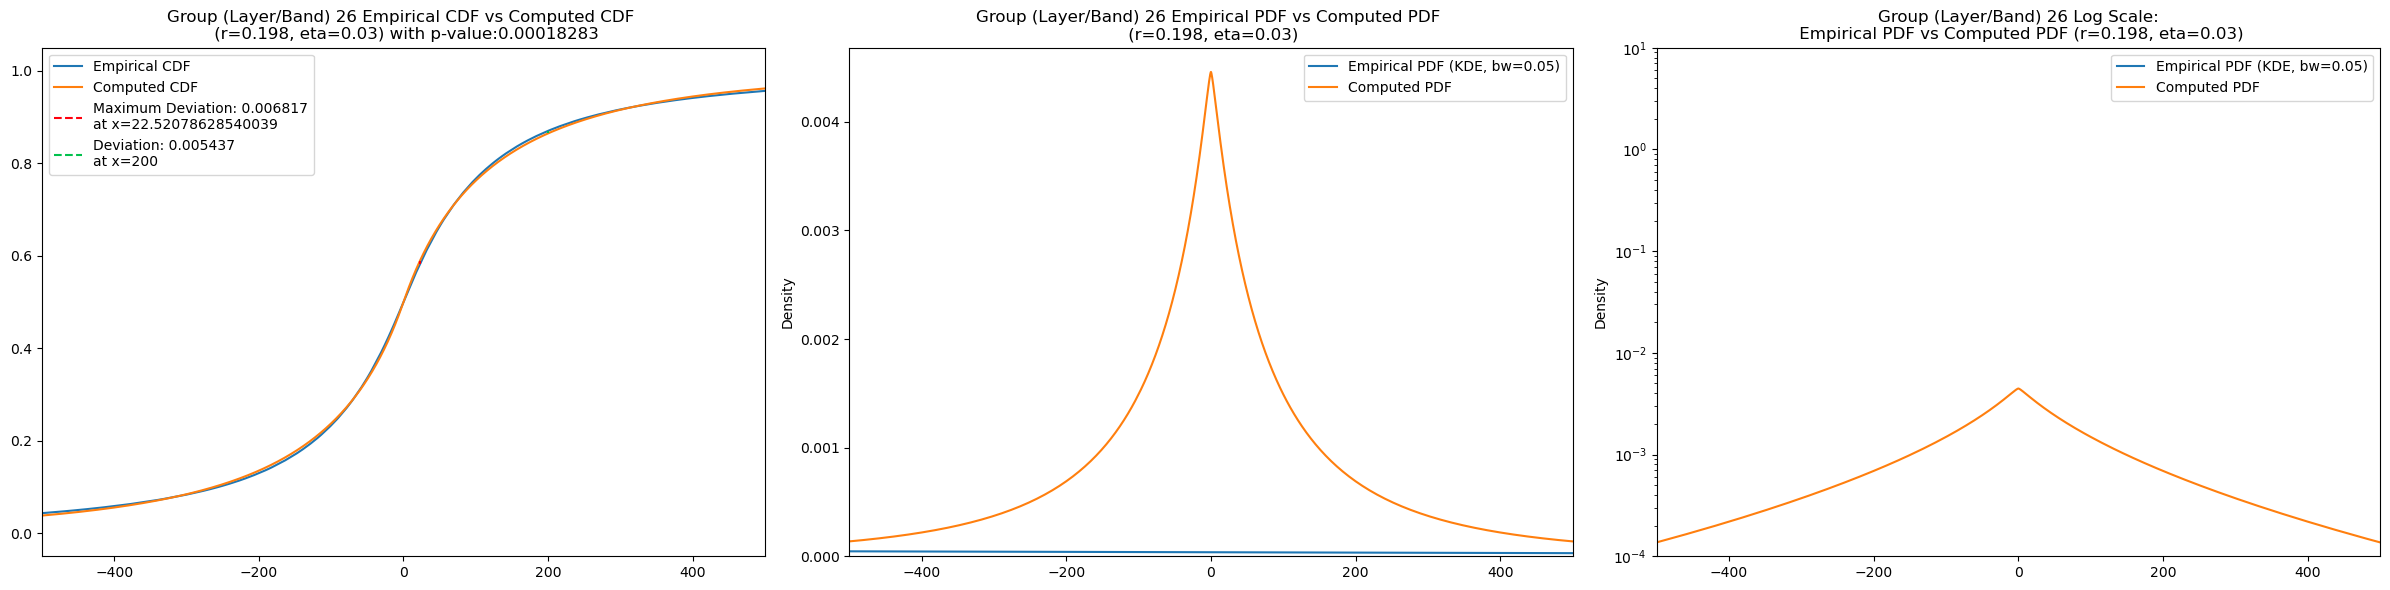

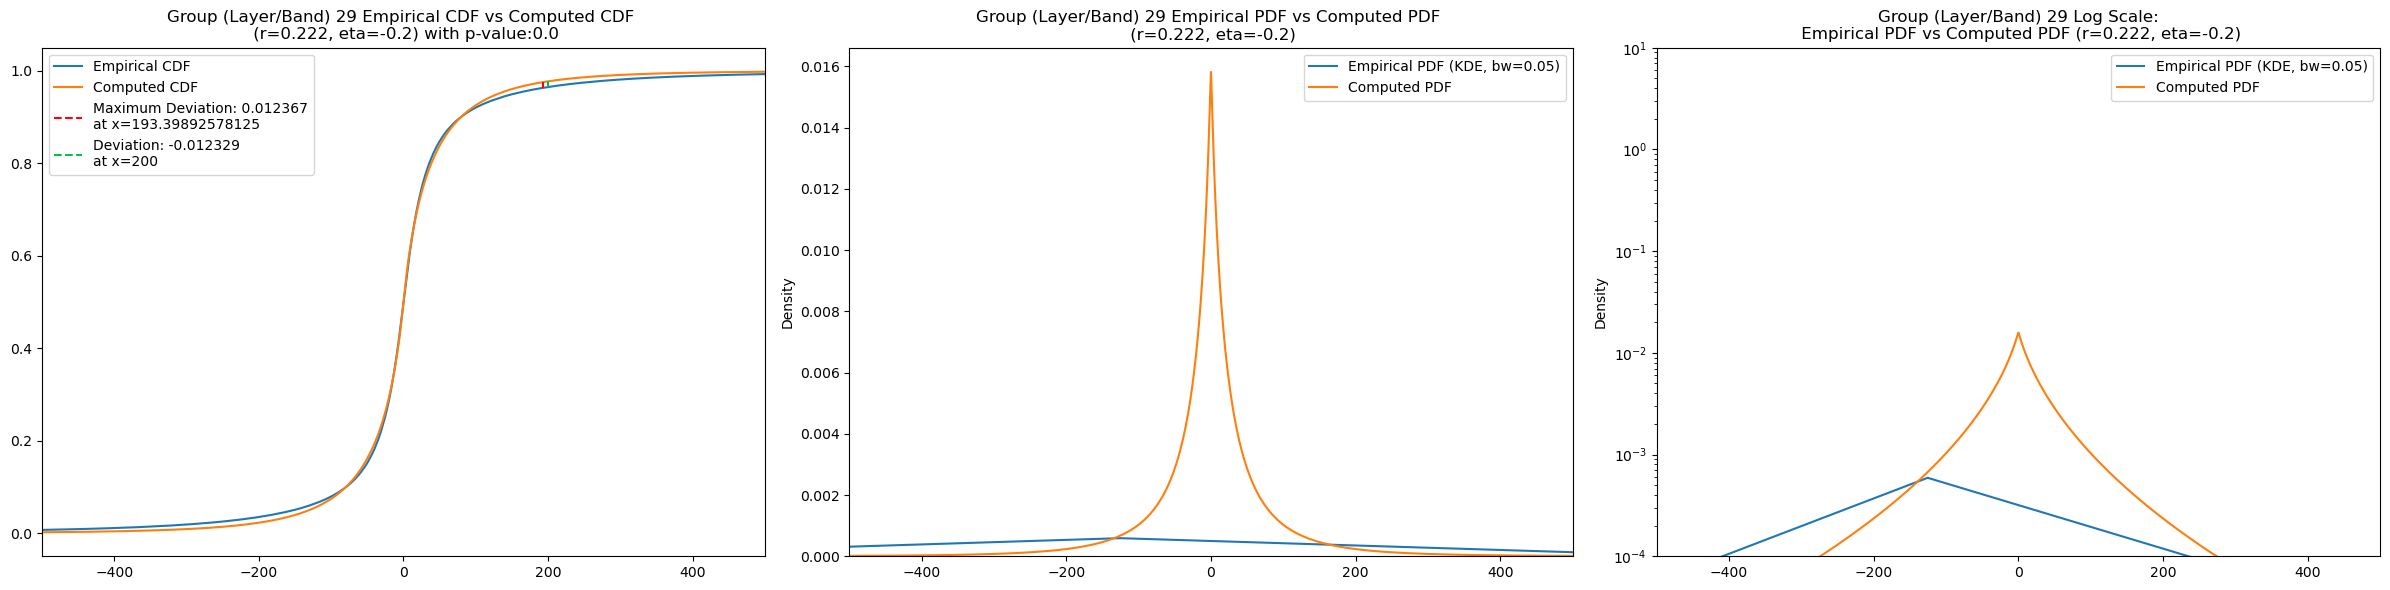

In [13]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta), 
                    log_scale = True,
                    group = group,
                    interval = (-500, 500),
                    provided_loc=200)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [14]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior', 't'")

In [15]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,299433540.0,1.759341e+08,509074180.0,473.18463,99.150400,1014.4304,45000.0,0.16,1.0,0.012473,...,5561.470,0.046405,1.197360e-84,4952.6400,0.021000,1.140300e-17,3921.3400,0.018083,3.261500e-13,3.678149e-03
5,198747680.0,9.555501e+07,699319550.0,2945.43360,103.131584,5357.3315,117000.0,0.17,1.3,0.012226,...,3885.580,0.045041,1.059590e-206,3450.6300,0.020023,3.543130e-41,2723.1400,0.015456,1.040890e-24,1.789395e-09
8,63282876.0,3.527536e+07,138901260.0,918.95044,92.981850,2773.2476,189000.0,0.17,1.0,0.011484,...,2579.320,0.040807,6.612170e-274,2298.2100,0.015836,1.333470e-41,1810.0900,0.012473,5.695210e-26,4.097868e-06
11,36580880.0,1.483858e+07,157073860.0,6517.12160,79.522800,6402.9790,495000.0,0.18,1.2,0.005725,...,1873.480,0.038185,0.000000e+00,1663.0400,0.012965,1.044880e-72,1320.8200,0.010806,1.236700e-50,2.145182e-09
14,11849475.0,6.219774e+06,33301018.0,1856.47970,73.469666,4078.7040,1134000.0,0.18,0.9,0.004487,...,1298.890,0.038303,0.000000e+00,1146.5000,0.011968,1.671050e-141,921.1070,0.011081,2.201120e-121,7.909457e-08
17,7712681.0,2.961589e+06,38807548.0,9698.96400,65.483850,7453.9814,2574000.0,0.19,1.0,0.008769,...,925.135,0.039225,0.000000e+00,815.6550,0.012917,0.000000e+00,655.2060,0.011227,3.249540e-282,6.081918e-15
20,4424362.0,1.715440e+06,23333856.0,8663.62000,69.634030,7121.5830,5967000.0,0.20,1.2,0.008976,...,654.557,0.042153,0.000000e+00,577.9810,0.016380,0.000000e+00,462.1010,0.012944,0.000000e+00,NaN
23,1867623.2,6.293671e+05,12235534.0,16824.38000,62.493916,8304.5210,13887000.0,0.20,0.7,0.011148,...,382.708,0.044811,0.000000e+00,338.9470,0.019541,0.000000e+00,269.3710,0.014836,0.000000e+00,0.000000e+00
26,1038924.0,1.669297e+05,9786948.0,32372.20000,72.067810,9321.7900,31968000.0,0.20,0.1,0.012022,...,168.668,0.050555,0.000000e+00,150.2400,0.025412,0.000000e+00,118.1190,0.020596,0.000000e+00,0.000000e+00


In [16]:
# def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
#     if metric_name == 'kstest_ratio':
#         metric = compute_ksratio
#     elif metric_name == 'kstest_stat':
#         metric = compute_ksstat_tail

#     for tail_cutoff in tail_cutoffs:
#         metrics = []
#         for layer in layers:
#             if distro == 'gengamma':
#                 cdf = all_cdfs[(master_df.loc[layer, 'initial_r'], master_df.loc[layer, 'initial_eta'])]
#             elif distro == 'gaussian':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
#             elif distro == 'laplace':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
#             elif distro == 't':
#                 cdf = scipy.stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
#             metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
#         master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
# for group in GROUPS:
#     add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
#     add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

# master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

# master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
# master_df

## Results

In [17]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [18]:
master_df#.filter(regex='total_samples|kstest_stat.*')
#master_df.filter(regex='total_samples|param.*')
# master_df.filter(regex='.*gaussian')
#master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,299433540.0,1.759341e+08,509074180.0,473.18463,99.150400,1014.4304,45000.0,0.16,1.0,0.012473,...,5561.470,0.046405,1.197360e-84,4952.6400,0.021000,1.140300e-17,3921.3400,0.018083,3.261500e-13,3.678149e-03
5,198747680.0,9.555501e+07,699319550.0,2945.43360,103.131584,5357.3315,117000.0,0.17,1.3,0.012226,...,3885.580,0.045041,1.059590e-206,3450.6300,0.020023,3.543130e-41,2723.1400,0.015456,1.040890e-24,1.789395e-09
8,63282876.0,3.527536e+07,138901260.0,918.95044,92.981850,2773.2476,189000.0,0.17,1.0,0.011484,...,2579.320,0.040807,6.612170e-274,2298.2100,0.015836,1.333470e-41,1810.0900,0.012473,5.695210e-26,4.097868e-06
11,36580880.0,1.483858e+07,157073860.0,6517.12160,79.522800,6402.9790,495000.0,0.18,1.2,0.005725,...,1873.480,0.038185,0.000000e+00,1663.0400,0.012965,1.044880e-72,1320.8200,0.010806,1.236700e-50,2.145182e-09
14,11849475.0,6.219774e+06,33301018.0,1856.47970,73.469666,4078.7040,1134000.0,0.18,0.9,0.004487,...,1298.890,0.038303,0.000000e+00,1146.5000,0.011968,1.671050e-141,921.1070,0.011081,2.201120e-121,7.909457e-08
17,7712681.0,2.961589e+06,38807548.0,9698.96400,65.483850,7453.9814,2574000.0,0.19,1.0,0.008769,...,925.135,0.039225,0.000000e+00,815.6550,0.012917,0.000000e+00,655.2060,0.011227,3.249540e-282,6.081918e-15
20,4424362.0,1.715440e+06,23333856.0,8663.62000,69.634030,7121.5830,5967000.0,0.20,1.2,0.008976,...,654.557,0.042153,0.000000e+00,577.9810,0.016380,0.000000e+00,462.1010,0.012944,0.000000e+00,NaN
23,1867623.2,6.293671e+05,12235534.0,16824.38000,62.493916,8304.5210,13887000.0,0.20,0.7,0.011148,...,382.708,0.044811,0.000000e+00,338.9470,0.019541,0.000000e+00,269.3710,0.014836,0.000000e+00,0.000000e+00
26,1038924.0,1.669297e+05,9786948.0,32372.20000,72.067810,9321.7900,31968000.0,0.20,0.1,0.012022,...,168.668,0.050555,0.000000e+00,150.2400,0.025412,0.000000e+00,118.1190,0.020596,0.000000e+00,0.000000e+00
